In [2]:
import numpy as np
import torch as th
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import os, glob, tqdm
import torchvision.transforms.functional as F
from torchvision.io import read_image
from pathlib import Path
import cv2
from torchvision.utils import make_grid

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    fig.set_size_inches(18, 6)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        
def face_segment(segment_part, img):
    
    if isinstance(img, Image.Image):
        face_segment_anno = np.array(img)
    else:
        face_segment_anno = img
        
    bg = (face_segment_anno == 0)
    skin = (face_segment_anno == 1)
    l_brow = (face_segment_anno == 2)
    r_brow = (face_segment_anno == 3)
    l_eye = (face_segment_anno == 4)
    r_eye = (face_segment_anno == 5)
    eye_g = (face_segment_anno == 6)
    l_ear = (face_segment_anno == 7)
    r_ear = (face_segment_anno == 8)
    ear_r = (face_segment_anno == 9)
    nose = (face_segment_anno == 10)
    mouth = (face_segment_anno == 11)
    u_lip = (face_segment_anno == 12)
    l_lip = (face_segment_anno == 13)
    neck = (face_segment_anno == 14)
    neck_l = (face_segment_anno == 15)
    cloth = (face_segment_anno == 16)
    hair = (face_segment_anno == 17)
    hat = (face_segment_anno == 18)
    face = np.logical_or.reduce((skin, l_brow, r_brow, l_eye, r_eye, eye_g, l_ear, r_ear, ear_r, nose, mouth, u_lip, l_lip))

    if segment_part == 'faceseg_face':
        seg_m = face
    elif segment_part == 'faceseg_head':
        seg_m = (face | neck | hair)
    elif segment_part == 'faceseg_nohead':
        seg_m = ~(face | neck | hair)
    elif segment_part == 'faceseg_face&hair':
        seg_m = ~bg
    elif segment_part == 'faceseg_bg_noface&nohair':
        seg_m = (bg | hat | neck | neck_l | cloth) 
    elif segment_part == 'faceseg_bg&ears_noface&nohair':
        seg_m = (bg | hat | neck | neck_l | cloth) | (l_ear | r_ear | ear_r)
    elif segment_part == 'faceseg_bg':
        seg_m = bg
    elif segment_part == 'faceseg_bg&noface':
        seg_m = (bg | hair | hat | neck | neck_l | cloth)
    elif segment_part == 'faceseg_hair':
        seg_m = hair
    elif segment_part == 'faceseg_faceskin':
        seg_m = skin
    elif segment_part == 'faceseg_faceskin&nose':
        seg_m = (skin | nose)
    elif segment_part == 'faceseg_faceskin&nose&mouth&eyebrows':
        seg_m = (skin | nose | mouth | u_lip | l_lip | l_brow | r_brow | l_eye | r_eye)
    elif segment_part == 'faceseg_faceskin&nose&mouth&eyebrows&eyes&glasses':
        seg_m = (skin | nose | mouth | u_lip | l_lip | l_brow | r_brow | l_eye | r_eye | eye_g)
        # seg_m = (skin | nose | mouth | u_lip | l_lip | l_brow | r_brow)
    elif segment_part == 'faceseg_face_noglasses':
        seg_m = (~eye_g & face)
    elif segment_part == 'faceseg_face_noglasses_noeyes':
        seg_m = (~(l_eye | r_eye) & ~eye_g & face)
    elif segment_part == 'faceseg_eyes&glasses':
        seg_m = (l_eye | r_eye | eye_g)
    elif segment_part == 'glasses':
        seg_m = eye_g
    elif segment_part == 'faceseg_eyes':
        seg_m = (l_eye | r_eye)
    elif segment_part == 'faceseg_eyebrows':
        seg_m = (l_brow | r_brow)
    elif segment_part == 'faceseg_mouth':
        seg_m = mouth
    # elif (segment_part == 'sobel_bg_mask') or (segment_part == 'laplacian_bg_mask') or (segment_part == 'sobel_bin_bg_mask'):
    elif segment_part in ['sobel_bg_mask', 'laplacian_bg_mask', 'sobel_bin_bg_mask']:
        seg_m = ~(face | neck | hair)
    elif segment_part in ['canny_edge_bg_mask']:
        seg_m = ~(face | neck | hair) | (l_ear | r_ear)
    else: raise NotImplementedError(f"Segment part: {segment_part} is not found!")
    
    out = seg_m
    return out

def get_shadow_diff(img1, img2, c_type='L', signed=False):
    # Compute Shadow Difference
    img1 = np.array(img1.convert(c_type)) / 255.0
    img2 = np.array(img2.convert(c_type)) / 255.0
    if signed:
        shadow_diff = img2 - img1
    else:
        shadow_diff = np.abs(img2 - img1)
    return shadow_diff

def create_image_grid(images, n_rows=1, text_labels=[]):
    """
    Creates a grid of images from a list of NumPy arrays.
    
    Parameters:
    - images: List of np.array, each representing an image.
    - n_rows: Number of rows in the grid.
    
    Returns:
    - A matplotlib figure containing the image grid.
    """
    n_images = len(images)
    n_cols = (n_images + n_rows - 1) // n_rows  # Calculate number of columns needed
    
    # Get the height and width of the images (assuming all images are the same size)
    # img_height, img_width = images[0].shape[:2]

    # Add zero images if the number of images is less than needed to fill the grid
    images += [np.zeros_like(images[0]) for _ in range(n_rows * n_cols - n_images)]
    
    # Create the grid by concatenating images
    rows = []
    for i in range(n_rows):
        row_images = images[i * n_cols:(i + 1) * n_cols]
        rows.append(np.concatenate(row_images, axis=1))
    
    grid_image = np.concatenate(rows, axis=0)

    # Add text labels to the grid
    img_height, img_width = images[0].shape[:2]
    for i, text_label in enumerate(text_labels):
        # plt.text((i % n_cols) * img_width, (i // n_cols) * img_height, text_label, color='red', fontsize=12)
        if isinstance(text_label, str):
            plt.text((i % n_cols) * img_width, -2, text_label, color='red', fontsize=20)
        else:
            plt.text((i % n_cols) * img_width, -2, f'{float(text_label):.5f}', color='red', fontsize=20)

    return grid_image


(256, 256) [  0 127 255]


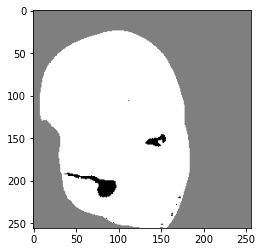

In [35]:
data_path = '/data/mint/DPM_Dataset/ffhq_256_with_anno/'
set_ = 'valid'
shadow_diff_path = f'{data_path}/shadow_diff/median5_5e-2/{set_}'

sd = sorted(glob.glob(f'{shadow_diff_path}/*.png'))
sd = np.array(Image.open(sd[150]))
print(sd.shape, np.unique(sd))
plt.imshow(sd, cmap='gray')
plt.show()

In [74]:
data_path = '/data/mint/DPM_Dataset/ffhq_256_with_anno/'
set_ = 'valid'
shadow_diff_path = f'{data_path}/shadow_diff_with_weight_simplified/{set_}'

# sd = sorted(glob.glob(f'{shadow_diff_path}/*.npy'))
# sd = np.load(sd[150])
# print(sd.shape, np.unique(sd))
# plt.imshow(sd, cmap='gray')
# plt.show()

out_dir = f'{data_path}/shadow_diff_binary_simplified/{set_}'
os.makedirs(out_dir, exist_ok=True)
# Convert to binary (0. is 0., otherwise 1.)
for i, sd_path in enumerate(tqdm.tqdm(sorted(glob.glob(f'{shadow_diff_path}/*.npy')))):
    sd_sim = np.load(sd_path)
    sd_sim = np.repeat(sd_sim, 3, axis=2)
    # plt.imshow(sd_sim)
    # plt.show()
    sd_bin = (sd_sim > 0.) * 1.0
    # print(np.unique(sd_sim))
    # print(np.unique(sd_bin))
    # print(sd_bin.shape)
    # plt.imshow(sd_bin)
    # plt.show()
    assert np.all(sd_bin[..., 0] == sd_bin[..., 1]) and np.all(sd_bin[..., 1] == sd_bin[..., 2])

    img_name = Path(sd_path).name
    np.save(file=f'{out_dir}/{img_name}', arr=sd_bin[..., 0])
    # if i == 10:
    #     assert False

100%|██████████| 10000/10000 [10:16<00:00, 16.23it/s]


(256, 256) [0. 1.]


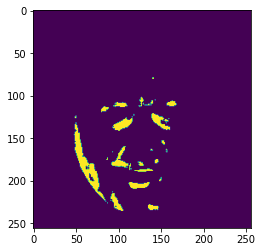

In [73]:
tmp = np.load(f'{out_dir}/{img_name}')
print(tmp.shape, np.unique(tmp))
plt.imshow(tmp)
plt.show()
